In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import re, csv
from nltk.corpus import stopwords
import nltk
import string
from nltk import word_tokenize
from gensim.models import KeyedVectors   
from sklearn.preprocessing import LabelEncoder
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer


import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
# from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.utils import to_categorical
from keras.initializers import Constant

Using TensorFlow backend.


In [2]:
## load a pickle file
train_df = pd.read_pickle("train_cleaned.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [3]:
train_df.head()

,tweet_id,text,hashtags,emotion,identification,stop_words,sentimentText,stemming,lemmazation,text_tokenized,cleaned
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],anticipation,train,"People post ""add #Snapchat"" must dehydrated. C...","People post ""add #Snapchat"" must dehydrated. C...","peopl post ""add #snapchat"" must dehydrated. cu...","peopl post ""add #snapchat"" must dehydrated. cu...","[peopl, post, add, snapchat, must, dehydrated,...",peopl post add snapchat must dehydrated cuz ma...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",sadness,train,"@brianklaas As see, Trump dangerous #freepress...","@brianklaas As see, Trump dangerous #freepress...","@brianklaa As see, trump danger #freepress aro...","@brianklaa As see, trump danger #freepress aro...","[brianklaa, As, see, trump, danger, freepress,...",brianklaa As see trump danger freepress around...
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],fear,train,Now ISSA stalking Tasha 😂😂😂 <LH>,Now ISSA stalking Tasha 😂😂😂 <LH>,now issa stalk tasha 😂😂😂 <lh>,now issa stalk tasha 😂😂😂 <lh>,"[now, issa, stalk, tasha, 😂😂😂, lh]",now issa stalk tasha 😂😂😂 lh
5,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",joy,train,@RISKshow @TheKevinAllison Thx BEST TIME tonig...,@RISKshow @TheKevinAllison Thank You BEST TIME...,@riskshow @thekevinallison thank you best time...,@riskshow @thekevinallison thank you best time...,"[riskshow, thekevinallison, thank, you, best, ...",riskshow thekevinallison thank you best time t...
6,0x2c91a8,Still waiting on those supplies Liscus. <LH>,[],anticipation,train,Still waiting supplies Liscus. <LH>,Still waiting supplies Liscus. <LH>,still wait suppli liscus. <lh>,still wait suppli liscus. <lh>,"[still, wait, suppli, liscus, lh]",still wait suppli liscus lh


## test_df preprosscessing

In [4]:
tknr = Tokenizer(num_words=None, 
               filters='!"#$%&()*,-./:;<=>?@[\]^_`{|}~ ', 
               lower=True, 
               split=' ', 
               char_level=False, 
               oov_token=None, 
               document_count=0)

In [5]:
tokenizer = RegexpTokenizer("[\w']+")
filt = '[!"#$%&()*,-./:;<=>?@[\]^_`{|}~ ]'
test_df['split'] = test_df['text'].apply(lambda x: re.sub(filt, ' ', x))
test_df['split'] = test_df['split'].apply(lambda x: re.sub(" \d+", " ", x))
test_df['split'] = test_df['split'].apply(lambda x: x.split(" "))
#test_df['split'] = test_df['text'].map(tokenizer.tokenize)
#train_df['split'] = train_df['text'].map(tokenizer.tokenize)

In [6]:
print(test_df.loc[1867515]['split'])

['My', 'baby', 'currently', 'thinks', 'naps', 'are', 'the', 'devil', '😒', '', 'LH', '']


In [7]:
test_df[-10:]

,hashtags,tweet_id,text,emotion,identification,split
1867508,[],0x388aad,My printer prints off all our devices but wont...,NaN,test,"[My, printer, prints, off, all, our, devices, ..."
1867515,[],0x298005,My baby currently thinks naps are the devil 😒 ...,NaN,test,"[My, baby, currently, thinks, naps, are, the, ..."
1867519,[Eagles],0x378811,Jake Elliott sets a new #Eagles record with 5 ...,NaN,test,"[Jake, Elliott, sets, a, new, , Eagles, record..."
1867521,[],0x365a44,This planet really makes me sad.... THE NRA do...,NaN,test,"[This, planet, really, makes, me, sad, , , , ,..."
1867522,[],0x32183f,I ate a donut and now I feel like throwing up ...,NaN,test,"[I, ate, a, donut, and, now, I, feel, like, th..."
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",NaN,test,"[, For, this, is, the, message, that, ye, hear..."
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",NaN,test,"[, There, is, a, lad, here, , which, hath, fiv..."
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test,"[When, you, buy, the, last, , tickets, remaini..."
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test,"[I, swear, all, this, hard, work, gone, pay, o..."
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test,"[, Parcel2Go, no, card, left, when, I, wasn't,..."


In [8]:
stop_words = set(stopwords.words('english'))
#train_df['no_stopwords'] = train_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
test_df['no_stopwords'] = test_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
test_df['no_stopwords'] = test_df['no_stopwords'].apply(lambda x: [item for item in x if len(item) > 1])

In [9]:
set(test_df.loc[9]['no_stopwords'])

{'Is',
 'LH',
 'When',
 'enough',
 'goal',
 'materialism',
 'money',
 'possessions',
 'really',
 'satisfied'}

In [10]:
print(test_df.loc[1867515]['text'])
print(test_df.loc[1867515]['no_stopwords'])

My baby currently thinks naps are the devil 😒 <LH>
['My', 'baby', 'currently', 'thinks', 'naps', 'devil', 'LH']


In [11]:
test_df[-10:]

,hashtags,tweet_id,text,emotion,identification,split,no_stopwords
1867508,[],0x388aad,My printer prints off all our devices but wont...,NaN,test,"[My, printer, prints, off, all, our, devices, ...","[My, printer, prints, devices, wont, laptop, I..."
1867515,[],0x298005,My baby currently thinks naps are the devil 😒 ...,NaN,test,"[My, baby, currently, thinks, naps, are, the, ...","[My, baby, currently, thinks, naps, devil, LH]"
1867519,[Eagles],0x378811,Jake Elliott sets a new #Eagles record with 5 ...,NaN,test,"[Jake, Elliott, sets, a, new, , Eagles, record...","[Jake, Elliott, sets, new, Eagles, record, fie..."
1867521,[],0x365a44,This planet really makes me sad.... THE NRA do...,NaN,test,"[This, planet, really, makes, me, sad, , , , ,...","[This, planet, really, makes, sad, THE, NRA, l..."
1867522,[],0x32183f,I ate a donut and now I feel like throwing up ...,NaN,test,"[I, ate, a, donut, and, now, I, feel, like, th...","[ate, donut, feel, like, throwing, LH]"
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",NaN,test,"[, For, this, is, the, message, that, ye, hear...","[For, message, ye, heard, beginning, love, one..."
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",NaN,test,"[, There, is, a, lad, here, , which, hath, fiv...","[There, lad, hath, five, barley, loaves, two, ..."
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test,"[When, you, buy, the, last, , tickets, remaini...","[When, buy, last, tickets, remaining, show, se..."
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test,"[I, swear, all, this, hard, work, gone, pay, o...","[swear, hard, work, gone, pay, one, day😈💰💸, LH]"
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test,"[, Parcel2Go, no, card, left, when, I, wasn't,...","[Parcel2Go, card, left, idea, get, parcel, LH]"


In [12]:
porter = nltk.stem.PorterStemmer()

#train_df['stemmed'] = train_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])
test_df['stemmed'] = test_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])

In [13]:
lemmatizer = WordNetLemmatizer() 
#train_df['lemmatization'] = train_df['stemmed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
test_df['lemmatization'] = test_df['stemmed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [14]:
#train_df['cleaned'] = train_df['lemmatization'].apply(' '.join)
test_df['cleaned'] = test_df['lemmatization'].apply(' '.join)

In [15]:
test_df[-10:]

,hashtags,tweet_id,text,emotion,identification,split,no_stopwords,stemmed,lemmatization,cleaned
1867508,[],0x388aad,My printer prints off all our devices but wont...,NaN,test,"[My, printer, prints, off, all, our, devices, ...","[My, printer, prints, devices, wont, laptop, I...","[My, printer, print, devic, wont, laptop, It, ...","[My, printer, print, devic, wont, laptop, It, ...",My printer print devic wont laptop It print te...
1867515,[],0x298005,My baby currently thinks naps are the devil 😒 ...,NaN,test,"[My, baby, currently, thinks, naps, are, the, ...","[My, baby, currently, thinks, naps, devil, LH]","[My, babi, current, think, nap, devil, LH]","[My, babi, current, think, nap, devil, LH]",My babi current think nap devil LH
1867519,[Eagles],0x378811,Jake Elliott sets a new #Eagles record with 5 ...,NaN,test,"[Jake, Elliott, sets, a, new, , Eagles, record...","[Jake, Elliott, sets, new, Eagles, record, fie...","[jake, elliott, set, new, eagl, record, field,...","[jake, elliott, set, new, eagl, record, field,...",jake elliott set new eagl record field goal ya...
1867521,[],0x365a44,This planet really makes me sad.... THE NRA do...,NaN,test,"[This, planet, really, makes, me, sad, , , , ,...","[This, planet, really, makes, sad, THE, NRA, l...","[thi, planet, realli, make, sad, the, nra, lov...","[thi, planet, realli, make, sad, the, nra, lov...",thi planet realli make sad the nra love social LH
1867522,[],0x32183f,I ate a donut and now I feel like throwing up ...,NaN,test,"[I, ate, a, donut, and, now, I, feel, like, th...","[ate, donut, feel, like, throwing, LH]","[ate, donut, feel, like, throw, LH]","[ate, donut, feel, like, throw, LH]",ate donut feel like throw LH
1867525,[],0x2913b4,"""For this is the message that ye heard from th...",NaN,test,"[, For, this, is, the, message, that, ye, hear...","[For, message, ye, heard, beginning, love, one...","[for, messag, ye, heard, begin, love, one, ano...","[for, messag, ye, heard, begin, love, one, ano...",for messag ye heard begin love one anoth john ...
1867529,[],0x2a980e,"""There is a lad here, which hath five barley l...",NaN,test,"[, There, is, a, lad, here, , which, hath, fiv...","[There, lad, hath, five, barley, loaves, two, ...","[there, lad, hath, five, barley, loav, two, sm...","[there, lad, hath, five, barley, loav, two, sm...",there lad hath five barley loav two small fish...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test,"[When, you, buy, the, last, , tickets, remaini...","[When, buy, last, tickets, remaining, show, se...","[when, buy, last, ticket, remain, show, sell, ...","[when, buy, last, ticket, remain, show, sell, ...",when buy last ticket remain show sell mixedfee...
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test,"[I, swear, all, this, hard, work, gone, pay, o...","[swear, hard, work, gone, pay, one, day😈💰💸, LH]","[swear, hard, work, gone, pay, one, day😈💰💸, LH]","[swear, hard, work, gone, pay, one, day😈💰💸, LH]",swear hard work gone pay one day😈💰💸 LH
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test,"[, Parcel2Go, no, card, left, when, I, wasn't,...","[Parcel2Go, card, left, idea, get, parcel, LH]","[parcel2go, card, left, idea, get, parcel, LH]","[parcel2go, card, left, idea, get, parcel, LH]",parcel2go card left idea get parcel LH


In [16]:
tknzr = TweetTokenizer()
# TF-IDF
MAX_WORD = 15000


tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_WORD, 
    use_idf=True, 
    token_pattern='(?u)\\b[^\\d\\W][^\\d\\W]+\\b', 
#     tokenizer=tknzr.tokenize,
#     stop_words=stopwords.words('english')
    )
tfidf_vectorizer.fit(train_df['cleaned'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=15000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b[^\\d\\W][^\\d\\W]+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)

In [17]:
token_dict = {}
for idx, token in enumerate(tfidf_vectorizer.get_feature_names()):
    token_dict[token] = idx

In [18]:
word2vec_model = KeyedVectors.load_word2vec_format("../../Word2Vec/model_ENC3.bin", binary=True)

In [19]:
EMBEDDING_DIM = 300
# MAX_WORD = 5000
def word2vec_matrix():
#     token_dict = tknr.word_index()
    matrix_emb = np.zeros((len(token_dict)+1, EMBEDDING_DIM)) # replace MAX_WORD to len(token_dict)
    for word, idx in token_dict.items():
        try:
            vector =  word2vec_model.wv[word]
        except:
            vector = np.zeros(300,)
#         if idx < MAX_WORD and vector:
        if idx < MAX_WORD:
            matrix_emb[idx] = np.array(vector)
    matrix_emb[MAX_WORD] = np.zeros(300,)     
    return matrix_emb

In [20]:
MAX_SEQUENCE_LENGTH = 50

def text_to_sequence(texts):
    tokenized_texts = []
    for string in texts:
        tokenized_text = []
        for idx, word in enumerate(string.split(' ')):
            
            # truncate
            if idx >= MAX_SEQUENCE_LENGTH: break 
                
            try:
                token = token_dict[word.lower()]
            except:
                token = MAX_WORD
            tokenized_text.append(token)
            
        # padding 
        if len(tokenized_text) < MAX_SEQUENCE_LENGTH: 
#             print(len(tokenized_text))
            tokenized_text.extend([MAX_WORD]*(MAX_SEQUENCE_LENGTH-len(tokenized_text)))
                
        tokenized_texts.append(tokenized_text)
    

#     print(max([len(texts) for texts in tokenized_texts]))
    return np.array(tokenized_texts)

In [21]:
emotion_array = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise','trust']

In [22]:
def emotion_to_sequence(emotions):
    tokenized_emotions = []
    for string in emotions:
        token = emotion_array.index(string)
#         print(token)
        tokenized_emotions.append(token)
    return to_categorical(tokenized_emotions)

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(emotion_array)

print('check label: ', label_encoder.classes_)
def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)
def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


In [24]:
# shuffle dataset
train_df = train_df.sample(frac=1)

In [25]:
train_sequence = text_to_sequence(train_df['cleaned'])
train_label = emotion_to_sequence(train_df['emotion'])

test_sequence = text_to_sequence(test_df['cleaned'])


In [28]:
LSTM1_DIM = 256
# LSTM2_DIM = 200
DENSE1_DIM = 512
DENSE2_DIM = 512
CATEGORY_NUM = 8
BATCH_SIZE = 1000
VALIDATION_SPLIT = 0.2
EPOCHS = 6

csv_logger = CSVLogger('log/training_log_LSTM_prototype.csv')
                    

def model_setting(texts, labels, matrix_emb="uniform"):
    #######################################
    # build up the model 
    # input: texts (dataframe), labels (dataframe), embedding matrix (np array), model name (str)
    # output: None
    #######################################
    
    import numpy as np
    import pandas as pd
    DROPOUT = 0.2
    
    if matrix_emb != "uniform": matrix_emb = Constant(matrix_emb)
    
#     split data to train & validation
    validation_size = int(texts.shape[0]*VALIDATION_SPLIT)
    texts_train = texts[:-validation_size]
    texts_val = texts[-validation_size:]
    labels_train = labels[:-validation_size]
    labels_val = labels[-validation_size:]
    
    # model build
    model = Sequential()
#     model.add(Dropout(0.1, input_shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(Embedding(MAX_WORD+1, EMBEDDING_DIM, embeddings_initializer=matrix_emb, input_length=MAX_SEQUENCE_LENGTH, trainable=True)) # with embedding matrix
#     model.add(Embedding(MAX_WORD, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)) # without embedding matrix
#     model.add(LSTM(LSTM1_DIM, dropout=DROPOUT, recurrent_dropout=DROPOUT, return_sequences=True))
    model.add(LSTM(LSTM1_DIM, dropout=DROPOUT, recurrent_dropout=DROPOUT))

#     model.add(Bidirectional(LSTM(LSTM1_DIM, dropout=DROPOUT, recurrent_dropout=DROPOUT)))
#     model.add(LSTM(LSTM2_DIM, dropout=DROPOUT, recurrent_dropout=DROPOUT))
#     model.add(Bidirectional(LSTM(LSTM2_DIM)))
    model.add(Dense(DENSE1_DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(DENSE2_DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(CATEGORY_NUM, kernel_initializer='normal', activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
    model.summary()

    
    history_callback = model.fit(
        texts_train, 
        labels_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        callbacks=[csv_logger],
        verbose=1, 
        shuffle=True, 
        validation_data=(texts_val, labels_val))
    
    pred_result = model.predict(test_sequence, batch_size=128)
    
    pred_result_val = model.predict(texts_val, batch_size=128)

    return history_callback, pred_result, labels_val, pred_result_val

In [29]:
history, pred_result, labels_val, pred_result_val  = model_setting(train_sequence, train_label, word2vec_matrix())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           4500300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
Total params: 5,204,308
Trainable params: 5,204,308
Non-trainable params: 0
_________________________________________________________________
Train on 1164451 samples, validate on 291112 samples
Epoch 1/7
1164451/1164451 [==============================

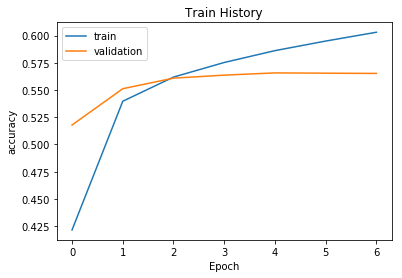

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

df_his_acc = pd.DataFrame({'train_acc':history.history['accuracy'], 'validation_acc':history.history['val_accuracy']})
df_his_acc.to_csv("train_acc_history.csv")
show_train_history(history, 'accuracy', 'val_accuracy')


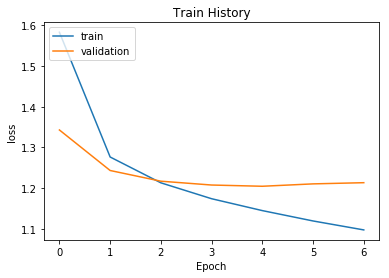

In [31]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
df_his_acc = pd.DataFrame({'train_loss':history.history['loss'], 'validation_loss':history.history['val_loss']})
df_his_acc.to_csv("train_loss_history.csv")
show_train_history(history, 'loss', 'val_loss')

In [32]:
pred_result_testing = label_decode(label_encoder, pred_result)

In [33]:
pred_result_testing

array(['anticipation', 'anticipation', 'joy', ..., 'sadness', 'anger',
       'sadness'], dtype='<U12')

In [34]:
pred_form = test_df
pred_form = pred_form.drop('hashtags', axis=1)
pred_form = pred_form.drop('text', axis=1)
pred_form = pred_form.drop('identification', axis=1)
pred_form = pred_form.drop('split', axis=1)
pred_form = pred_form.drop('no_stopwords', axis=1)
pred_form = pred_form.drop('stemmed', axis=1)
pred_form = pred_form.drop('lemmatization', axis=1)
pred_form = pred_form.drop('cleaned', axis=1)
pred_form.rename(columns={'tweet_id':'id'}, inplace=True)
pred = pred_form
pred['emotion'] = pred_result_testing

In [35]:
pred

,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,anticipation
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,sadness
1867531,0x29d0cb,anger


In [36]:
pred.to_csv('prediction_LSTM.csv', index=False)

In [37]:
from sklearn.metrics import classification_report
labels_val_decode = label_decode(label_encoder, labels_val)
pred_result_val_decode = label_decode(label_encoder, pred_result_val)
print(classification_report(y_true=labels_val_decode, y_pred=pred_result_val_decode))

              precision    recall  f1-score   support

       anger       0.52      0.22      0.31      7984
anticipation       0.59      0.63      0.61     49485
     disgust       0.46      0.40      0.43     27857
        fear       0.61      0.44      0.51     12774
         joy       0.59      0.77      0.67    103239
     sadness       0.48      0.53      0.50     38929
    surprise       0.69      0.20      0.31      9755
       trust       0.61      0.32      0.42     41089

   micro avg       0.57      0.57      0.57    291112
   macro avg       0.57      0.44      0.47    291112
weighted avg       0.57      0.57      0.55    291112

